In [1]:
import numpy as np
import pandas as pd

from os.path import join
from os import makedirs
from glob import glob
import re

from tqdm import tqdm

import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dir_behav = '/mnt/ext6/GL/behav_data'
dir_reg = join(dir_behav, 'regressors/Reward')

In [3]:
stat = 'Reward.0s_shifted'
shift = int(*re.findall(r'\d+', stat))
print(shift)
dir_output = join('/home/sungbeenpark/Github/labs/GL/behav_data/regressors/%s'%stat)
makedirs(dir_output, exist_ok=True)

0


In [4]:
list_subj = ['03','04','05','06','07',
             '08','09','10','11','12',
             '14','15','16','17','18',
             '19','20','21','22','24',
             '25','26','27','29']

In [5]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [6]:
def func_AMregressor(datum):
    sec = 4
    nS = int(datum['nSampleTrial'][0][0]) # 4 s * 60 Hz = 240 samples
    assert sec*60==nS

    ntrial = 12
    nblock = 12
    tpr = datum['nTrialperRun'][0][0]     # the number of trials per run = 1 trial+ 12 trial/block * 12 blocks
    assert 1+ntrial*nblock==tpr

    onsettime = datum['LearnTrialStartTime'][0]
    idx_editpoint = [i+1 for i,t in enumerate(onsettime[:-2]) if (onsettime[i]>onsettime[i+1])]
    assert (np.diff(idx_editpoint)==tpr).all() # Are you sure the fact that 145 trials per run?

    nrun = int(datum['nRun'][0][0])       # the number of runs = 6 runs
    targetID = datum['targetID'][0][idx_editpoint[0]:] # targetID.shape = 870 trials = 145 trial/run * 6 runs
    assert targetID.shape==tpr*nrun

    ## onset times
    tmp = np.zeros((nrun, tpr), dtype=float)
    for run in range(nrun):
        idx = idx_editpoint[run]
        tmp[run,:] = onsettime[idx:idx+tpr]*0.001
    onsettime=tmp

    ## counting how many times did they hit the target
    hit_or_not = np.zeros((tpr*nrun, nS), dtype=bool) # hit_or_not.shape = (# of trials/run, # if frames/trial)
    for t, ID in enumerate(targetID):
        pos = datum['boxSize']*convert_ID(ID) # r_target = [x_target, y_target]
        ## allXY.shape = (2, 60 Hz * 4 s/trial * 145 trials/run * 6 runs = 208800 frames)
        xy = datum['allXY'][:,nS*t:nS*(t+1)] # r_cursor = [x_cursor, y_cursor]
        ## err.shape = (2, nS)
        err = xy - np.ones((2,nS))*pos.T # dr = r_cursor - r_target
        ## is the cursor in the target box?
        hit_or_not[t,:] = (abs(err[0,:]) <= datum['boxSize']*0.5) & (abs(err[1,:]) <= datum['boxSize']*0.5)

    cnt_hit = hit_or_not.reshape(nrun, tpr, sec, 60).sum(axis=(2,3))

    return onsettime, cnt_hit

In [7]:
# rew = {}
for nn in list_subj:
# for nn in ['03']:
    subj = 'GL'+nn
    datum = scipy.io.loadmat(join(dir_behav, '%s-fmri.mat'%subj))

    nrun=6
    sec=4

    onsettime, cnt_hit = func_AMregressor(datum)
    reward = cnt_hit/(sec*60)

    AM2 = [[],[],[],[],[],[]]
    for run in range(nrun):
#         ## cut off the first trial
#         AM2[run] = ['%.1f*%.3f'%(o,r) for o,r in zip(onsettime[run][1:], reward[run][1:])]
        ## 4s shift, After every trial, a reward was received in full.
        AM2[run] = ['%.1f*%.3f'%(o,r) for o,r in zip(onsettime[run]+shift, reward[run])]

    np.savetxt(
        join(dir_output, '%s_reward.txt'%subj)
        , X=AM2, fmt='%s', delimiter=' ', newline='\n'
    )

#     ## test df
#     tmp = []
#     for run in range(nrun):
#         tmp.append(reward[run][1:].reshape(12,12).mean(axis=-1))
#     rew[subj]=np.concatenate(tmp)
#     df = pd.DataFrame.from_dict(rew, orient='index', dtype=float)

Text(0.5, 0, 'blocks')

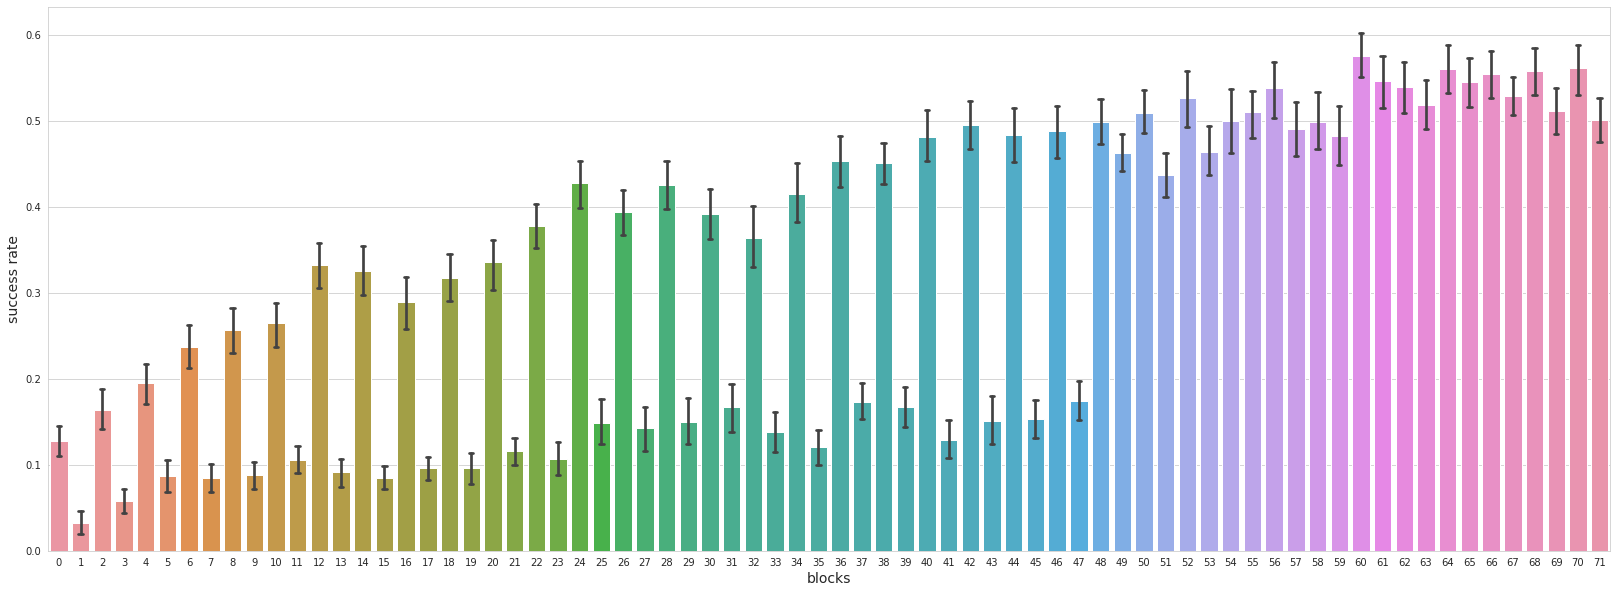

In [31]:
# plt.figure(figsize=(28, 10))
# sns.set_style('whitegrid')
# sns.barplot(data=df[range(72)], ci=68, capsize=.2)
# plt.ylabel('success rate', size=14)
# plt.xlabel('blocks', size=14)